# Hyperparameter Optimization for Stance Classification (OPTUNA)

The goal of this notebook is to optimize the macro F1-score of a stance classification model using hyperparameter optimization (HPO) techniques with Optuna.
We fine-tune our winner model (Best Performance) on a balanced dataset (Previously Augmented) of tweets labeled as support or oppose.

We incorporate:
- Bayesian Optimization (TPE Sampler) to efficiently explore the hyperparameter space.
- Early Stopping to prevent overfitting by stopping training.
- Pruning (Median Pruner) to terminate unpromising trials early and save GPU time.
- Evaluation Metrics: Accuracy, Precision, Recall, and F1-score (macro).

In [2]:
# Libraries
import os
import re
import numpy as np
import pandas as pd
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, EarlyStoppingCallback
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
import torch
import ast
import matplotlib.pyplot as plt
import optuna
from optuna.pruners import MedianPruner
from optuna.samplers import TPESampler
import warnings
import json
warnings.filterwarnings('ignore')

# Google Colab or not
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    path = "/content/drive/MyDrive/multimodal-argmining"
    os.chdir(path)
    print(f"Loading data from Google Drive: {path}")
else:
    path = "C:/Users/diego/Desktop/Master Neuro/M2/Intership_NLP/multimodal-argmining"
    os.chdir(path)
    print(f"Loading data locally from: {path}")


# GPU
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU ready:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("No GPU detecting, using CPU.")

#If we use the augmented dataset:
augmented = True

# Set Seed
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

c:\Users\diego\anaconda3\envs\multimodal\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading data locally from: C:/Users/diego/Desktop/Master Neuro/M2/Intership_NLP/multimodal-argmining
No GPU detecting, using CPU.


In [3]:
# Load Dataset
if augmented:
  train_path = f"{path}/data/train_augmented_paraphrase.csv"
else:
  train_path = f"{path}/data/train.csv"

dev_path   = f"{path}/data/dev.csv"
test_path  = f"{path}/data/test.csv"

df_train = pd.read_csv(train_path)
df_dev   = pd.read_csv(dev_path)
df_test  = pd.read_csv(test_path)


# Map labels to ints
label2id = {"oppose": 0, "support": 1}

#Minimal Preprocessing
def clean_tweet(text):

    text = str(text)
    #URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    return text


for df in [df_train, df_dev, df_test]:
    #df["tweet_text"] = df["tweet_text"].apply(clean_tweet) Based on our experiment we remove any cleaning to keep the original tweet
    df["label"] = df["stance"].map(label2id)


dataset_train = Dataset.from_pandas(df_train[["tweet_text","label"]])
dataset_dev   = Dataset.from_pandas(df_dev[["tweet_text","label"]])
dataset_test  = Dataset.from_pandas(df_test[["tweet_text","label"]])

In [4]:
# We define our Model
MODEL_NAME = "roberta-base"
MAX_LEN=105

In [5]:
# Load Tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
print(f"Tokenizer loaded: {MODEL_NAME}")


# Tokenization Function for each model
def tokenize_dataset(dataset, tokenizer, max_length=MAX_LEN):

    def tokenize_batch(batch):
        return tokenizer(batch["tweet_text"],padding="max_length",truncation=True,max_length=max_length)

    #Tokenization
    tokenized = dataset.map(tokenize_batch, batched=True)

    #Dataset Format for PyTorch
    tokenized.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

    return tokenized

# Tokenize datasets with model tokenizer
train_dataset_tok = tokenize_dataset(dataset_train, tokenizer, MAX_LEN)
dev_dataset_tok = tokenize_dataset(dataset_dev, tokenizer, MAX_LEN)
test_dataset_tok = tokenize_dataset(dataset_test, tokenizer, MAX_LEN)

print(f"Tokenization complete")

Tokenizer loaded: roberta-base


Map: 100%|██████████| 300/300 [00:00<00:00, 4382.63 examples/s]

Tokenization complete


In [6]:
# We define our Metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, preds)
    f1_macro = f1_score(labels, preds, average="macro")
    precision = precision_score(labels, preds, average="macro")
    recall = recall_score(labels, preds, average="macro")
    return {"accuracy": acc,"f1": f1_macro,"precision": precision,"recall": recall}

### Hyperparameter Optimization - OPTUNA

In [7]:
BASELINE_CONFIG = {
    "learning_rate": 2e-5,
    "weight_decay": 0.01,
    "batch_size": 16,
    "num_train_epochs": 5,
    "warmup_ratio": 0.0,
    "dropout": 0.1}

print("Baseline Config:")
for key, value in BASELINE_CONFIG.items():
    print(f"{key}: {value}")

Baseline Config:
learning_rate: 2e-05
weight_decay: 0.01
batch_size: 16
num_train_epochs: 5
warmup_ratio: 0.0
dropout: 0.1


In [8]:
# Objective Function for Hyperparameter Optimization (OPTUNA) - F1 Score (Macro)
def objective(trial):

    #Hyperparameters to optimize

    # Our search space
    if trial.number > 0:
        learning_rate = trial.suggest_float("learning_rate", 1e-5, 5e-5, log=True) 
        weight_decay = trial.suggest_float("weight_decay", 0.0, 0.1)
        per_device_train_batch_size = trial.suggest_categorical("batch_size", [8, 16, 32])
        num_train_epochs = trial.suggest_int("num_train_epochs", 3, 7)  
        warmup_ratio = trial.suggest_float("warmup_ratio", 0.0, 0.2)
        dropout = trial.suggest_float("dropout", 0.05, 0.2) 
    else:
        # First trial: Use BASELINE configuration (Performance Benchmark and Data Augmentation notebooks)
        print(f"\n Trial {trial.number}: Using BASELINE configuration")
        learning_rate = BASELINE_CONFIG["learning_rate"]
        weight_decay = BASELINE_CONFIG["weight_decay"]
        per_device_train_batch_size = BASELINE_CONFIG["batch_size"]
        num_train_epochs = BASELINE_CONFIG["num_train_epochs"]
        warmup_ratio = BASELINE_CONFIG["warmup_ratio"]
        dropout = BASELINE_CONFIG["dropout"]
    
    
    print(f"\nTrial {trial.number} hyperparameters:")
    print(f"  LR: {learning_rate:.2e}, Batch: {per_device_train_batch_size}, "
          f"Epochs: {num_train_epochs}, WD: {weight_decay:.3f}, "
          f"Warmup: {warmup_ratio:.2f}, Dropout: {dropout:.2f}")

    f1_score = train_single_trial(
    trial=trial,
    learning_rate=learning_rate,
    weight_decay=weight_decay,
    per_device_train_batch_size=per_device_train_batch_size,
    num_train_epochs=num_train_epochs,
    warmup_ratio=warmup_ratio,
    dropout=dropout,
    seed=seed)

    return f1_score

def train_single_trial(trial, learning_rate, weight_decay, per_device_train_batch_size,
                      num_train_epochs, warmup_ratio, dropout, seed):
    
    # Set seed for reproducibility
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    
    # Load Model for this trial
    model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME,
                                                               num_labels=2,
                                                               hidden_dropout_prob=dropout,
                                                               attention_probs_dropout_prob=dropout).to(device)
    
    # Training Arguments
    training_args = TrainingArguments(
        output_dir=f"./optuna-trial-{trial.number}-seed{seed}",
        eval_strategy="epoch",
        save_strategy="epoch",
        logging_strategy="epoch",
        learning_rate=learning_rate,
        per_device_train_batch_size=per_device_train_batch_size,
        per_device_eval_batch_size=per_device_train_batch_size,
        num_train_epochs=num_train_epochs,
        weight_decay=weight_decay,
        warmup_ratio=warmup_ratio,
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        save_total_limit=1,
        report_to="none",
        logging_steps=10,
        seed=seed,  # Reproducibility
        data_seed=seed,  # Reproducibility
    )
    
    # Trainer with Early Stopping
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset_tok,
        eval_dataset=dev_dataset_tok,
        processing_class=tokenizer,  
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
    )
    
    # Train
    trainer.train()
    
    # Final evaluation on dev set
    final_metrics = trainer.evaluate(dev_dataset_tok)
    f1_macro = final_metrics["eval_f1"]
    
    print(f"  Trial {trial.number} (seed {seed}) - F1: {f1_macro:.4f}")
    
    # Cleanup to save memory
    del model
    del trainer
    torch.cuda.empty_cache() if torch.cuda.is_available() else None
    
    return f1_macro

We use **TPESampler** because it efficiently explores the hyperparameter space by learning from previous trials. Unlike random search, it focuses on promising regions, increasing the chances of finding optimal hyperparameters faster and with fewer trials. It is especially useful for mixed spaces with continuous, integer, and categorical parameters.

In [9]:
print("STARTING HYPERPARAMETER OPTIMIZATION")

study = optuna.create_study(direction="maximize",
                            sampler=TPESampler(seed=seed),
                            pruner=MedianPruner(n_warmup_steps=2, n_startup_trials=3)) 


trails = 20
study.optimize(objective, n_trials=trails, timeout=None)

[I 2025-11-06 11:35:28,691] A new study created in memory with name: no-name-1303a9e1-4957-4c6d-bb97-0739fffb0a8c


STARTING HYPERPARAMETER OPTIMIZATION

 Trial 0: Using BASELINE configuration

Trial 0 hyperparameters:
  LR: 2.00e-05, Batch: 16, Epochs: 5, WD: 0.010, Warmup: 0.00, Dropout: 0.10


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss


[W 2025-11-06 11:35:59,246] Trial 0 failed with parameters: {} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\Users\diego\anaconda3\envs\multimodal\lib\site-packages\optuna\study\_optimize.py", line 201, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\diego\AppData\Local\Temp\ipykernel_32292\4007185028.py", line 30, in objective
    f1_score = train_single_trial(
  File "C:\Users\diego\AppData\Local\Temp\ipykernel_32292\4007185028.py", line 90, in train_single_trial
    trainer.train()
  File "c:\Users\diego\anaconda3\envs\multimodal\lib\site-packages\transformers\trainer.py", line 2325, in train
    return inner_training_loop(
  File "c:\Users\diego\anaconda3\envs\multimodal\lib\site-packages\transformers\trainer.py", line 2674, in _inner_training_loop
    tr_loss_step = self.training_step(model, inputs, num_items_in_batch)
  File "c:\Users\diego\anaconda3\envs\multimodal\lib\site-packages\transformers\trainer.py", l

KeyboardInterrupt: 

### Optimization Results

In [ ]:
print("Optimization completed.")
print("\n BEST TRAIL:")
print("\n BEST TRIAL:")
print(f"  Trial number: {study.best_trial.number}")
print(f"  F1 Score: {study.best_trial.value:.4f}")
print("\n  Best hyperparameters:")
for key, value in study.best_trial.params.items():
    print(f"    {key}: {value}")

# Compare with baseline
baseline_trial = study.trials[0]
print(f"\n BASELINE PERFORMANCE (Trial 0):")
print(f"  F1 Score: {baseline_trial.value:.4f}")
improvement = study.best_trial.value - baseline_trial.value
print(f"\n Improvement over baseline: {improvement:+.4f} ({improvement/baseline_trial.value*100:+.2f}%)")

In [ ]:
# Visualization Optimization History plot
fig = plt.figure(figsize=(10, 6))
# Plot 1: Optimization history
trial_numbers = [trial.number for trial in study.trials]
trial_values = [trial.value for trial in study.trials]

plt.plot(trial_numbers, trial_values, 'o-', alpha=0.7)
plt.axhline(y=baseline_trial.value, color='r', linestyle='--',
              label=f'Baseline (F1={baseline_trial.value:.4f})')
plt.axhline(y=study.best_trial.value, color='g', linestyle='--',
              label=f'Best (F1={study.best_trial.value:.4f})')
plt.xlabel('Trial Number', fontsize=12)
plt.ylabel('F1 Score', fontsize=12)
plt.title('Optimization History', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# We retrain the model with the best hyperparameters 

best_params = study.best_trial.params
print("\nRetraining best model with optimal hyperparameters...")

best_model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME,num_labels=2,
                                                                idden_dropout_prob=best_params["dropout"],
                                                                attention_probs_dropout_prob=best_params["dropout"]).to(device)

best_args = TrainingArguments(
    output_dir="./roberta_best",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    learning_rate=best_params["learning_rate"],
    per_device_train_batch_size=best_params["batch_size"],
    per_device_eval_batch_size=best_params["batch_size"],
    num_train_epochs=best_params["num_train_epochs"],
    weight_decay=best_params["weight_decay"],
    warmup_ratio=best_params["warmup_ratio"],
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    save_total_limit=1,
    report_to="none",
)

final_trainer = Trainer(
    model=best_model,
    args=best_args,
    train_dataset=train_dataset_tok,
    eval_dataset=dev_dataset_tok,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
)

final_trainer.train()

eval_results = final_trainer.evaluate(test_dataset_tok)
print("\nFinal evaluation on test set:", eval_results)

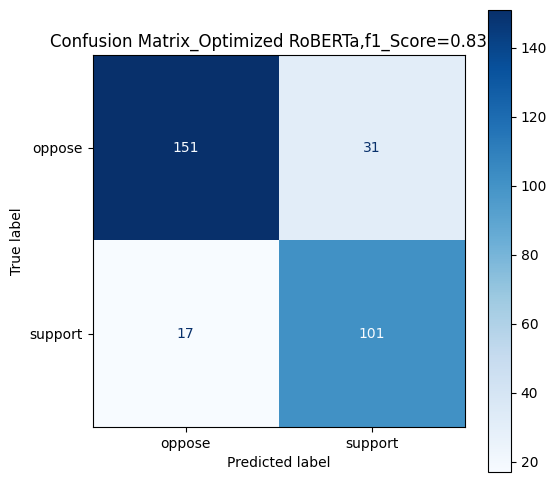

In [ ]:
# Path Output
os.makedirs(f"{path}/experiments/text/HPO/", exist_ok=True)
output_dir = f"{path}/experiments/text/HPO/"

# Confusion Matrix
preds_output = final_trainer.predict(test_dataset_tok)
y_true = preds_output.label_ids
y_pred = np.argmax(preds_output.predictions, axis=-1)
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["oppose", "support"])

# Export
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(cmap="Blues", values_format="d", ax=ax)
plt.title(f"Confusion Matrix_Optimized RoBERTa,f1_Score={eval_results['eval_f1']:.4f}")
save_path = os.path.join(output_dir,f"confusion_matrix_Model_Optimized.jpg")
plt.savefig(save_path, dpi=300, bbox_inches="tight")
plt.show()



In [ ]:
# Export metrics to CSV
results_df = eval_results[["eval_accuracy", "eval_f1", "eval_precision", "eval_recall"]]
results_df = pd.DataFrame(results_df).rename(columns={
    "eval_accuracy": "accuracy",
    "eval_f1": "f1",
    "eval_precision": "precision",
    "eval_recall": "recall"
})
results_df.to_csv(output_dir + "evaluation_results.csv", index=False)
print(f"Metrics saved to {output_dir}/evaluation_results.csv")
print(results_df)

Metrics saved to /content/drive/MyDrive/multimodal-argmining/experiments/text/HPO//evaluation_results.csv
   eval_loss  eval_accuracy   eval_f1  eval_precision  eval_recall  \
0   0.550406           0.84  0.835429        0.831981     0.842801   

   eval_runtime  eval_samples_per_second  eval_steps_per_second  epoch  \
0        1.8599                  161.297                 10.215    4.0   

   best_trial_f1_dev  
0           0.907486  


In [ ]:
# Export best hyperparameters to JSON
best_hyperparams = study.best_trial.params
with open(f"{output_dir}/best_hyperparameters.json", "w") as f:
    json.dump(best_hyperparams, f, indent=4)
print(f"Best hyperparameters saved to {output_dir}/best_hyperparameters.json")
print(best_hyperparams)

Best hyperparameters saved to /content/drive/MyDrive/multimodal-argmining/experiments/text/HPO//best_hyperparameters.json
{'learning_rate': 7.72537838930735e-06, 'weight_decay': 0.07080725777960455, 'batch_size': 16, 'num_train_epochs': 4, 'warmup_ratio': 0.03636499344142013, 'dropout': 0.055021352956030146}
